In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib.patches as patches
from collections import OrderedDict
from itertools import compress
from numpy import linspace, meshgrid
from matplotlib.mlab import griddata
from matplotlib import pyplot
from pylab import MaxNLocator
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import scipy.stats
import matplotlib
matplotlib.rc('font', family='Arial')
#import seaborn as sns

In [2]:
master = pd.read_excel('../data/ASF_12well_coculture_sample_list_20170117.xlsx')
# remove experiment 3sp
master = master[master['Run'] != '3sp']
# replace NAs with 0s
master = master.fillna(0)
# replace the values in the species column with strings, for convenience
master['species'] = master['species'].astype('str')
# remove samples from experiments where the species did not grow
master = master[~((master['species'].str.contains('492')) & (master['Run'] == 3))]
master = master[~((master['species'].str.contains('500')) & (master['Run'] == 3))]
master = master[~((master['species'].str.contains('502')) & (master['Run'] == 3))]
master = master[~((master['species'].str.contains('502')) & (master['Run'] == 2))]

In [3]:
qpcr_cols = [x for x in master.columns if str(x).startswith('qpcr')]
# rename qPCR columns by species number code
new_qpcr_cols = {x:x[x.find('(')+1:x.find('(')+4] for x in qpcr_cols}
master = master.rename(columns=new_qpcr_cols)

In [4]:
# calculate avg and std dev of monocultures across all 3 experiments
# so that z-scores can be calculated for all co-cultures.
species = ['356','360','361','492','500','519']
for specie in species:
    # subset the dataframe to only include monocultures
    monoculture = master[master['species'] == specie]
    # get the mean qPCR value for the monoculture
    species_mean = monoculture[specie].mean()
    species_std = monoculture[specie].std()
    # create new z_score column for the species
    master[specie+'Z'] = (master[specie] - species_mean)/species_std

In [5]:
# Load the differential abundance testing results
master_w_testing = master.copy()
all_diff_abundance = []
for specie in species:
    filename = specie+'_diff_abundance.txt'
    diff_abundance = pd.read_csv('../results/'+filename,sep='\t')
    diff_abundance['species'] = [entry[1] for entry in diff_abundance.index.str.split(' vs. ')]
    diff_abundance['mono_comparison'] = [entry[0] for entry in diff_abundance.index.str.split(' vs. ')]
    diff_abundance['species'] = diff_abundance['species'].str.replace(',',';')
    all_diff_abundance.append(diff_abundance)
    #if all_diff_abundance == []:
    #    all_diff_abundance = pd.concat([all_diff_abundance,diff_abundance])
    #else:
    #    all_diff_abundance = diff_abundance
all_diff_abundance = pd.concat(all_diff_abundance)    
#master_w_testing = pd.merge(master_w_testing,diff_abundance,on='species',how='outer')
master = pd.merge(master,all_diff_abundance,on='species',how='outer')

In [6]:
# position_dict = {str(['502', '519']):[7],
# str(['500', '519']):[14],
# str(['500', '502']):[15],
# str(['492', '519']):[21],
# str(['492', '502']):[22],
# str(['492', '500']):[23],
# str(['361', '519']):[28],
# str(['361', '502']):[29],
# str(['361', '500']):[30],
# str(['361', '492']):[31],
# str(['360', '519']):[35],
# str(['360', '502']):[36],
# str(['360', '500']):[37],
# str(['360', '492']):[38],
# str(['360', '361']):[39],
# str(['356', '519']):[42],
# str(['356', '502']):[43],
# str(['356', '500']):[44],
# str(['356', '492']):[45],
# str(['356', '361']):[46],
# str(['356', '360']):[47]}

# new version of position dictionary excluding ASF502
position_dict = {str(['500', '519']):[0],
str(['492', '519']):[5],
str(['492', '500']):[6],
str(['361', '519']):[10],
str(['361', '500']):[11],
str(['361', '492']):[12],
str(['360', '519']):[15],
str(['360', '500']):[16],
str(['360', '492']):[17],
str(['360', '361']):[18],
str(['356', '519']):[20],
str(['356', '500']):[21],
str(['356', '492']):[22],
str(['356', '361']):[23],
str(['356', '360']):[24]}

In [7]:
# Determine the unoccupied positions in the subplots so we can skip over them in the grid
all_pos = []
list_o_lists = list(position_dict.values())
for listy in list_o_lists:
    for entry in listy:
        all_pos.append(entry)
all_pos = list(set(all_pos))
possible = [1+i for i in range(-1,24)]
unnocupied = list(set(possible) - set(all_pos))
print(unnocupied)
print(all_pos)

[1, 2, 3, 4, 7, 8, 9, 13, 14, 19]
[0, 5, 6, 10, 11, 12, 15, 16, 17, 18, 20, 21, 22, 23, 24]


/usr/local/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


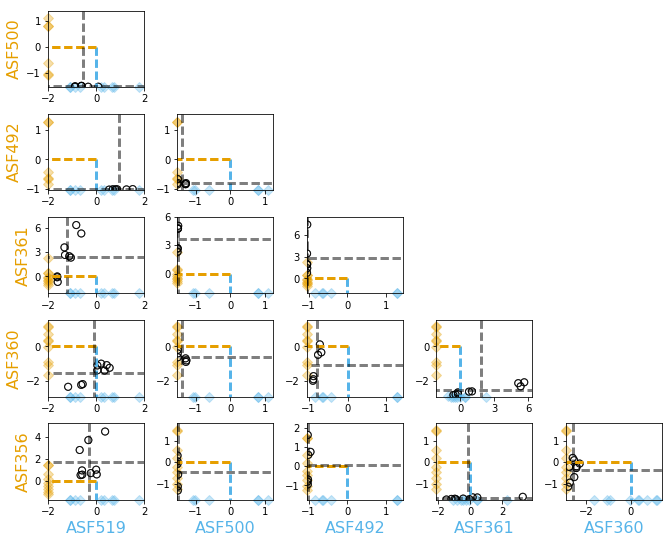

In [8]:
fig,axes = plt.subplots(5,5)

colors = {'black':(0,0,0),
          'orange':(230.0/255.0,159.0/255.0,0.0),
          'sky_blue':(86.0/255.0,180.0/255.0,233.0/255.0),
          'bluish_green':(0.0,158.0/255.0,115.0/255.0),
          'yellow':(240.0/255.0,228.0/255.0,66.0/255.0),
          'blue':(0.0,114.0/255.0,178.0/255.0),
          'vermillion':(213.0/255.0,94.0/255.0,0.0),
          'reddish_purple':(204.0/255.0,121.0/255.0,167.0/255.0)}

axes = np.ravel((axes))
species_used = []
for species_1 in species:
    species_used.append(species_1)
    species_1_df = master[master['species'] == species_1][species_1+'Z']
    
    for species_2 in species:
        if species_2 not in species_used:
            coculture = species_1 + ';' + species_2
            species_2_df = master[master['species'] == species_2][species_2+'Z']
            # get value for species 1 z-scores in species 2 samples
            species_1_cross = master[master['species'] == species_2][species_1+'Z']
            # get value for species 2 z-scores in species 1 samples
            species_2_cross = master[master['species'] == species_1][species_2+'Z']
            # get z scores for each species from coculture
            spec1_z_coculture = master[master['species'] == coculture][species_1+'Z']
            spec2_z_coculture = master[master['species'] == coculture][species_2+'Z']

             
            ax_index = position_dict[str([species_1,species_2])]
            ax = axes[ax_index][0]
            ax.scatter(species_2_cross,species_1_df,c=colors['orange'],alpha=0.33,s=50,marker='D',clip_on=False)
            ax.scatter(species_2_df,species_1_cross,c=colors['sky_blue'],alpha=0.33,s=50,marker='D',clip_on=False)
            ax.scatter(spec2_z_coculture,spec1_z_coculture,color='black',alpha=0.75,s=50,marker='o',facecolors="None")
            xlim = ax.get_xlim()
            ylim = ax.get_ylim()
            ax.plot(np.array([0,0]),np.array([0,ylim[0]]),'--',c=colors['sky_blue'],linewidth=3.0)#,alpha=0.5)
            ax.plot(np.array([0,xlim[0]]),np.array([0,0]),'--',c=colors['orange'],linewidth=3.0)#,alpha=0.5)
            # plot the mean and std. dev of the coculture as lines from the axes
            ax.plot(np.array([xlim[0],xlim[1]]),np.array([spec1_z_coculture.mean(),spec1_z_coculture.mean()]),'--',color='black',alpha=0.5,linewidth=3.0)
            ax.plot(np.array([spec2_z_coculture.mean(),spec2_z_coculture.mean()]),np.array([ylim[1],ylim[0]]),'--',color='black',alpha=0.5,linewidth=3.0)
            s1_stdev = spec1_z_coculture.std()
            s2_stdev = spec2_z_coculture.std()
            #ax.add_patch(patches.Rectangle((spec1_z_coculture.mean()-s1_stdev,ylim[0]),2*s1_stdev,spec2_z_coculture.mean()-ylim[0]))
            # reset the limits to match the minimum z-score for the other species (so monocultures are on axis)
            new_lower_y_lim = min(species_1_cross)
            new_lower_x_lim = min(species_2_cross)
            ax.set_xlim((new_lower_x_lim,xlim[1]))
            ax.set_ylim((new_lower_y_lim,ylim[1]))
            
            # force tick labels to be at integers only
            ya = ax.get_yaxis()
            ya.set_major_locator(MaxNLocator(integer=True))
            xa = ax.get_xaxis()
            xa.set_major_locator(MaxNLocator(integer=True))
            ax.locator_params(nbins=4)
# delete the unused axes
for ax_index in unnocupied:
    fig.delaxes(axes[ax_index])

# Add text labels indicating species
axes[0].set_ylabel('ASF500',fontsize=16,color=colors['orange'])
axes[5].set_ylabel('ASF492',fontsize=16,color=colors['orange'])
axes[10].set_ylabel('ASF361',fontsize=16,color=colors['orange'])
axes[15].set_ylabel('ASF360',fontsize=16,color=colors['orange'])
axes[20].set_ylabel('ASF356',fontsize=16,color=colors['orange'])

axes[20].set_xlabel('ASF519',fontsize=16,color=colors['sky_blue'])
axes[21].set_xlabel('ASF500',fontsize=16,color=colors['sky_blue'])
axes[22].set_xlabel('ASF492',fontsize=16,color=colors['sky_blue'])
axes[23].set_xlabel('ASF361',fontsize=16,color=colors['sky_blue'])
axes[24].set_xlabel('ASF360',fontsize=16,color=colors['sky_blue'])

#fig.locator_params(nticks=4)
fig.subplots_adjust(wspace=.35,hspace=0.35)
fig.set_size_inches(11,9)
plt.savefig('../results/qPCR_grid_20171115.svg',format='svg')

/usr/local/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


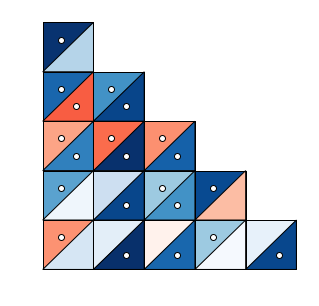

In [9]:
fig, ax = plt.subplots()
species_used = []
gridsize = 5 # grid will be 5x5 because we have 6 species
x_count = 0
y_count = 0
sig_thresh = 0.1
red_cmap = plt.get_cmap('Reds')
blue_cmap = plt.get_cmap('Blues')
for species_1 in species:
    species_used.append(species_1)
    species_1_df = master[master['species'] == species_1][species_1+'Z']
    
    for species_2 in species:
        if species_2 not in species_used:
            coculture = species_1 + ';' + species_2
            species_2_df = master[master['species'] == species_2][species_2+'Z']
            # get value for species 1 z-scores in species 2 samples
            species_1_cross = master[master['species'] == species_2][species_1+'Z']
            # get value for species 2 z-scores in species 1 samples
            species_2_cross = master[master['species'] == species_1][species_2+'Z']
            # get z scores for each species from coculture
            spec1_z_coculture = master[master['species'] == coculture][species_1+'Z']
            spec2_z_coculture = master[master['species'] == coculture][species_2+'Z']

            # determine the grid position for this combination
            grid_x_pos = 1 - x_count/gridsize
            grid_y_pos = y_count/gridsize
            
            # scale the z-scores from 0 to max
            upper_abundance = spec1_z_coculture.mean()/master[master['species'].str.find(species_1) > -1][species_1+'Z'].abs().max()
            lower_abundance = spec2_z_coculture.mean()/master[master['species'].str.find(species_2) > -1][species_2+'Z'].abs().max()

            # Get the value on the colormap for the co-culture abundance z-scores
            if upper_abundance > 0:
                upper_color = red_cmap(upper_abundance)
            else:
                upper_color = blue_cmap(-1.0*upper_abundance)

            if lower_abundance > 0:
                lower_color = red_cmap(lower_abundance)
            else:
                lower_color = blue_cmap(-1.0*lower_abundance)
            
            # upper left will be the x-label species, lower right will be the y-label species
            upper_triangle = Polygon(((grid_x_pos,grid_y_pos+1/gridsize),(grid_x_pos-1/gridsize,grid_y_pos+1/gridsize),(grid_x_pos-1/gridsize,grid_y_pos)),\
                       closed=True,edgecolor='black',facecolor=upper_color)
            # add expected triangle here:
            lower_triangle = Polygon(((grid_x_pos,grid_y_pos),(grid_x_pos-1/gridsize,grid_y_pos),(grid_x_pos,grid_y_pos+1/gridsize)),\
                       closed=True,edgecolor='black',facecolor=lower_color)
            outline_rectangle = Polygon(((grid_x_pos,grid_y_pos),(grid_x_pos-1/gridsize,grid_y_pos),(grid_x_pos-1/gridsize,grid_y_pos+1/gridsize),(grid_x_pos,grid_y_pos+1/gridsize)),\
                        closed=True,edgecolor='black',facecolor='none')
            plt.gca().add_patch(upper_triangle)
            plt.gca().add_patch(lower_triangle)
            plt.gca().add_patch(outline_rectangle)
            
            # get the result of the significance test (observed vs. expected) to annotate the plot
            upper_p = all_diff_abundance.loc[(all_diff_abundance['mono_comparison'] == species_1) &\
                       (all_diff_abundance['species'] == species_1+';'+species_2),]['final_p'].values[0]
            lower_p = all_diff_abundance.loc[(all_diff_abundance['mono_comparison'] == species_2) &\
                       (all_diff_abundance['species'] == species_1+';'+species_2),]['final_p'].values[0]
            if upper_p < sig_thresh:
                note = ax.plot(grid_x_pos-0.65*1/gridsize, grid_y_pos+0.65*1/gridsize,'o',color='white',markeredgecolor='black')
            if lower_p < sig_thresh:
                note = ax.plot(grid_x_pos-0.35*1/gridsize, grid_y_pos+0.3*1/gridsize,'o',color='white',markeredgecolor='black')
                
            
            x_count+=1
            if x_count == gridsize:
                y_count += 1 # go up one level
                x_count = 0 + y_count # reset to the rightmost x position at the new y level
fig.set_size_inches(5,5)
ax.axis('off')
plt.savefig('../results/coculture_abundance_triangle_heatmap.svg', bbox_inches='tight')


356
MannwhitneyuResult(statistic=311.0, pvalue=0.23793661740111438)
360
MannwhitneyuResult(statistic=97.0, pvalue=0.00016433127378176436)
361
MannwhitneyuResult(statistic=274.0, pvalue=0.11301490012549925)
492
MannwhitneyuResult(statistic=142.0, pvalue=0.16095753225202408)
500
MannwhitneyuResult(statistic=162.0, pvalue=0.28620842254734169)
519
MannwhitneyuResult(statistic=294.0, pvalue=0.17319458498901147)
356
MannwhitneyuResult(statistic=149.0, pvalue=0.011236521698537777)
360
MannwhitneyuResult(statistic=93.0, pvalue=0.00060628444256338938)
361
492
MannwhitneyuResult(statistic=70.0, pvalue=0.015934694036802401)
500
MannwhitneyuResult(statistic=90.0, pvalue=0.051996990274214817)
519
MannwhitneyuResult(statistic=132.0, pvalue=0.0050601075334345607)


/usr/local/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


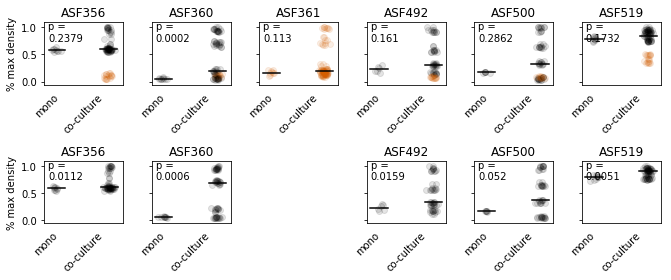

In [10]:
# Compare single species abundance to co-culture abundance.
# For each species, generate a new dataframe that is a subset of master, then add a column indicating a 
# biomass z-score calculated using the monoculture abundance.
fig,axes=plt.subplots(2,6,sharey=True)
axes = np.ravel((axes))
i = 0
shift = 0.5
median_width = 0.08
for specie in species:
    print(specie)
    subset = master.loc[master['species'].str.find(specie) > -1,]
    monocultures = subset.loc[subset['species'] == specie]['normalized_OD']
    cocultures = subset.loc[subset['species'] != specie]
    
    #before extracting coculture OD, get the index of samples containing ASF361 and set a plot color
    contains_361 = cocultures['species'].str.find('361') > -1
    color_dict = {True:(213/255,94/255,0),False:(0,0,0)}
    color_indicator = [color_dict[bool_value] for bool_value in contains_361]
    
    # convert to z-scores
    cocultures = cocultures['normalized_OD']
    mono_z = monocultures/max(monocultures.max(),cocultures.max())
    coculture_z = cocultures/max(monocultures.max(),cocultures.max())
    # compute mann-whitney rank test
    print(scipy.stats.mannwhitneyu(mono_z,coculture_z))
    test = scipy.stats.mannwhitneyu(mono_z,coculture_z)
    p = round(test.pvalue,4)
    
    x = np.append(np.zeros(len(mono_z)),(np.zeros(len(coculture_z))+shift))
    x = x + np.random.normal(0,0.02,len(x)) # add some jitter to x for plotting
    y = np.append(mono_z,coculture_z)
    
    # set the monoculture color
    if specie == '361':
        monoculture_color = (213/255,94/255,0)
    else:
        monoculture_color = (0,0,0)
    
    monoculture_color_indicator = [monoculture_color]*len(mono_z)
    # append the coculture plot colors to the monoculture colors
    final_plot_colors = monoculture_color_indicator + color_indicator
    
    
    ax=axes[i]
    for j in range(len(x)):
        ax.scatter(x[j],y[j],alpha=0.1,c=final_plot_colors[j])
    ax.plot([-median_width,median_width],[np.median(mono_z),np.median(mono_z)],'black')
    ax.plot([shift-median_width,shift+median_width],[np.median(coculture_z),np.median(coculture_z)],'black')
    ax.set_title('ASF'+specie)
    ax.tick_params(
        axis='x',
        which='both',
        top='off',
        bottom='off'
    )
    ax.set_xticks([0-0.2*shift,shift-0.5*shift])
    ax.set_xticklabels(labels=['mono','co-culture'],rotation=45)
    
    ax.annotate('p =\n'+str(p),xy=(0.05,0.70),xycoords='axes fraction')

    if i == 0:
        ax.set_ylabel('% max density')
    i +=1
    
    
# now repeat the visualization without ASF361, using the same set of axes to control figure size
for specie in species:
    print(specie)
    if specie == '361':
        fig.delaxes(axes[i])
        i += 1
    else:
        subset = master.loc[master['species'].str.find(specie) > -1,]
        subset = subset.loc[subset['species'].str.find('361') < 0,] # remove all the co-culture that contained 361

        monocultures = subset.loc[subset['species'] == specie]['normalized_OD']
        cocultures = subset.loc[subset['species'] != specie]

        #before extracting coculture OD, get the index of samples containing ASF361 and set a plot color
        contains_361 = cocultures['species'].str.find('361') > -1
        color_dict = {True:(213/255,94/255,0),False:(0,0,0)}
        color_indicator = [color_dict[bool_value] for bool_value in contains_361]

        # convert to z-scores
        cocultures = cocultures['normalized_OD']
        mono_z = monocultures/max(monocultures.max(),cocultures.max())
        coculture_z = cocultures/max(monocultures.max(),cocultures.max())
        # compute mann-whitney rank test
        print(scipy.stats.mannwhitneyu(mono_z,coculture_z))
        test = scipy.stats.mannwhitneyu(mono_z,coculture_z)
        p = round(test.pvalue,4)

        x = np.append(np.zeros(len(mono_z)),(np.zeros(len(coculture_z))+shift))
        x = x + np.random.normal(0,0.02,len(x)) # add some jitter to x for plotting
        y = np.append(mono_z,coculture_z)

        # set the monoculture color
        if specie == '361':
            monoculture_color = (213/255,94/255,0)
        else:
            monoculture_color = (0,0,0)

        monoculture_color_indicator = [monoculture_color]*len(mono_z)
        # append the coculture plot colors to the monoculture colors
        final_plot_colors = monoculture_color_indicator + color_indicator


        ax=axes[i]
        for j in range(len(x)):
            ax.scatter(x[j],y[j],alpha=0.1,c=final_plot_colors[j])
        ax.plot([-median_width,median_width],[np.median(mono_z),np.median(mono_z)],'black')
        ax.plot([shift-median_width,shift+median_width],[np.median(coculture_z),np.median(coculture_z)],'black')
        ax.set_title('ASF'+specie)
        ax.tick_params(
            axis='x',
            which='both',
            top='off',
            bottom='off'
        )
        ax.set_xticks([0-0.2*shift,shift-0.5*shift])
        ax.set_xticklabels(labels=['mono','co-culture'],rotation=45)

        ax.annotate('p =\n'+str(p),xy=(0.05,0.70),xycoords='axes fraction')

        if i == 0 or i == 6:
            ax.set_ylabel('% max density')
        i +=1

fig.tight_layout(w_pad=0.1)
fig.set_size_inches(10,4)
plt.savefig('../results/mono_vs_coculture_density.svg', bbox_inches='tight')
